# Statistical Threshold Model (Baseline)
Basic univariate detection with statistical quantile thresholds.

In [0]:
import pandas as pd
import math

import json

# Matplotlib for visualization at the end
import matplotlib.pyplot as plt

from pyspark.sql.functions import col, when, lit, udf
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

In [0]:
# Load selected features
feature_cols_json = dbutils.fs.head("dbfs:/tmp/feature_cols.json")
feature_cols = json.loads(feature_cols_json)
feature_cols

Out[2]: ['temperature_2m',
 'precipitation',
 'wind_speed_10m',
 'wind_speed_80m',
 'wind_speed_120m',
 'wind_speed_180m',
 'cloud_cover']

In [0]:
# Load data from DBFS
sdf = spark.table("historical_weather_hourly_lisbon")
display(sdf.limit(10))

time,temperature_2m,precipitation,wind_speed_10m,wind_speed_80m,wind_speed_120m,wind_speed_180m,cloud_cover,features,features_scaled
2025-03-17T06:00,11.6,0.1,2.9,13.6,17.7,18.8,83.0,"Map(vectorType -> dense, length -> 7, values -> List(11.6, 0.1, 2.9, 13.6, 17.7, 18.8, 83.0))","Map(vectorType -> dense, length -> 7, values -> List(-1.1228764848286579, 0.1032961123950345, -1.2036797775546113, -0.5039747038691812, -0.34803538323174504, -0.4649301367103813, 0.7526122039966409))"
2025-03-17T07:00,11.9,0.0,4.0,15.0,18.9,22.1,79.0,"Map(vectorType -> dense, length -> 7, values -> List(11.9, 0.0, 4.0, 15.0, 18.9, 22.1, 79.0))","Map(vectorType -> dense, length -> 7, values -> List(-1.0648974953189316, -0.19775002273369255, -0.9954240734305925, -0.35659793870921425, -0.2359272234209309, -0.19195234315693313, 0.649717708688776))"
2025-03-17T08:00,12.5,0.0,4.6,13.3,17.8,20.2,80.0,"Map(vectorType -> dense, length -> 7, values -> List(12.5, 0.0, 4.6, 13.3, 17.8, 20.2, 80.0))","Map(vectorType -> dense, length -> 7, values -> List(-0.9489395162994793, -0.19775002273369255, -0.8818300529993094, -0.5355554392606026, -0.33869303658084376, -0.34912137580891855, 0.6754413325157421))"
2025-03-17T09:00,13.9,0.1,9.4,16.2,22.9,27.3,100.0,"Map(vectorType -> dense, length -> 7, values -> List(13.9, 0.1, 9.4, 16.2, 22.9, 27.3, 100.0))","Map(vectorType -> dense, length -> 7, values -> List(-0.6783708985874239, 0.1032961123950345, 0.026922110450955737, -0.23027499714352842, 0.13776664261511654, 0.2381944830485002, 1.189913809055067))"
2025-03-17T10:00,15.0,1.0,12.8,22.5,23.9,25.4,89.0,"Map(vectorType -> dense, length -> 7, values -> List(15.0, 1.0, 12.8, 22.5, 23.9, 25.4, 89.0))","Map(vectorType -> dense, length -> 7, values -> List(-0.46578127038509476, 2.812711328553578, 0.6706215595615601, 0.4329204460763227, 0.23119010912412838, 0.08102545039651474, 0.9069539469584383))"
2025-03-17T11:00,15.3,0.5,15.0,27.4,29.6,31.4,100.0,"Map(vectorType -> dense, length -> 7, values -> List(15.3, 0.5, 15.0, 27.4, 29.6, 31.4, 100.0))","Map(vectorType -> dense, length -> 7, values -> List(-0.40780228087536846, 1.3074806529099428, 1.0871329678095982, 0.9487391241362066, 0.7637038682254962, 0.577348711402784, 1.189913809055067))"
2025-03-17T12:00,15.4,0.3,13.8,25.1,27.3,28.7,100.0,"Map(vectorType -> dense, length -> 7, values -> List(15.4, 0.3, 13.8, 25.1, 27.3, 28.7, 100.0))","Map(vectorType -> dense, length -> 7, values -> List(-0.3884759510387932, 0.7053883826524885, 0.8599449269470321, 0.7066201528019757, 0.5488298952547689, 0.3540032439499629, 1.189913809055067))"
2025-03-17T13:00,15.4,0.4,12.6,22.4,24.2,26.0,100.0,"Map(vectorType -> dense, length -> 7, values -> List(15.4, 0.4, 12.6, 22.4, 24.2, 26.0, 100.0))","Map(vectorType -> dense, length -> 7, values -> List(-0.3884759510387932, 1.0064345177812157, 0.6327568860844656, 0.422393534279182, 0.259217149076832, 0.13065777649714178, 1.189913809055067))"
2025-03-17T14:00,15.2,0.5,11.1,19.8,21.6,23.4,100.0,"Map(vectorType -> dense, length -> 7, values -> List(15.2, 0.5, 11.1, 19.8, 21.6, 23.4, 100.0))","Map(vectorType -> dense, length -> 7, values -> List(-0.42712861071194413, 1.3074806529099428, 0.3487718350062578, 0.14869382755352945, 0.01631613615340138, -0.08441563660557502, 1.189913809055067))"
2025-03-17T15:00,15.4,0.4,9.2,16.6,18.3,20.4,100.0,"Map(vectorType -> dense, length -> 7, values -> List(15.4, 0.4, 9.2, 16.6, 18.3, 20.4, 100.0))","Map(vectorType -> dense, length -> 7, values -> List(-0.3884759510387932, 1.0064345177812157, -0.010942563026138838, -0.18816734995496623, -0.2919813033263378, -0.33257726710870966, 1.189913809055067))"


In [0]:
# Threshold list builder
lower_q = 0.015
upper_q = 0.985

threshold_data = []

for feature in feature_cols:
    q_low, q_high = sdf.approxQuantile(feature, [lower_q, upper_q], 0.01)
    threshold_data.append((feature, float(q_low), float(q_high)))

schema = StructType([
    StructField("feature", StringType(), False),
    StructField("lower_threshold", DoubleType(), False),
    StructField("upper_threshold", DoubleType(), False)
])

threshold_sdf = spark.createDataFrame(threshold_data, schema)

# Save threshold list
# threshold_df.write.format("delta").mode("overwrite").save("/tmp/quantile_threshold_model")
# threshold_df.write.format("parquet").mode("overwrite").saveAsTable("quantile_thresholds")

display(threshold_sdf)


feature,lower_threshold,upper_threshold
temperature_2m,7.6,30.3
precipitation,0.0,0.9
wind_speed_10m,1.6,21.7
wind_speed_80m,3.2,44.4
wind_speed_120m,3.6,49.3
wind_speed_180m,3.6,55.4
cloud_cover,0.0,100.0


### Apply basic threshold model to training historical dataset

In [0]:
sdf_flagged = sdf

for row in threshold_data:
    feature, low, high = row
    sdf_flagged = sdf_flagged.withColumn(
        f"{feature}_anomaly",
        when((col(feature) < lit(low)) | (col(feature) > lit(high)), 1).otherwise(0)
    )

## Visualization for the historic year

In [0]:
plot_df = sdf_flagged.select(
    "time",
    "temperature_2m",
    "wind_speed_10m",
    "temperature_2m_anomaly",
    "wind_speed_10m_anomaly"
).orderBy("time").toPandas()

plot_df[plot_df["temperature_2m_anomaly"] != 0]

,time,temperature_2m,wind_speed_10m,temperature_2m_anomaly,wind_speed_10m_anomaly
182,2024-05-08T14:00,30.4,6.7,1,0
183,2024-05-08T15:00,31.0,1.6,1,0
687,2024-05-29T15:00,30.9,14.8,1,0
709,2024-05-30T13:00,30.6,9.1,1,0
710,2024-05-30T14:00,30.8,11.1,1,0
...,...,...,...,...,...
6752,2025-02-06T08:00,7.5,4.8,1,0
7014,2025-02-17T06:00,6.8,4.6,1,0
7015,2025-02-17T07:00,6.7,3.9,1,0
7016,2025-02-17T08:00,6.8,4.3,1,0


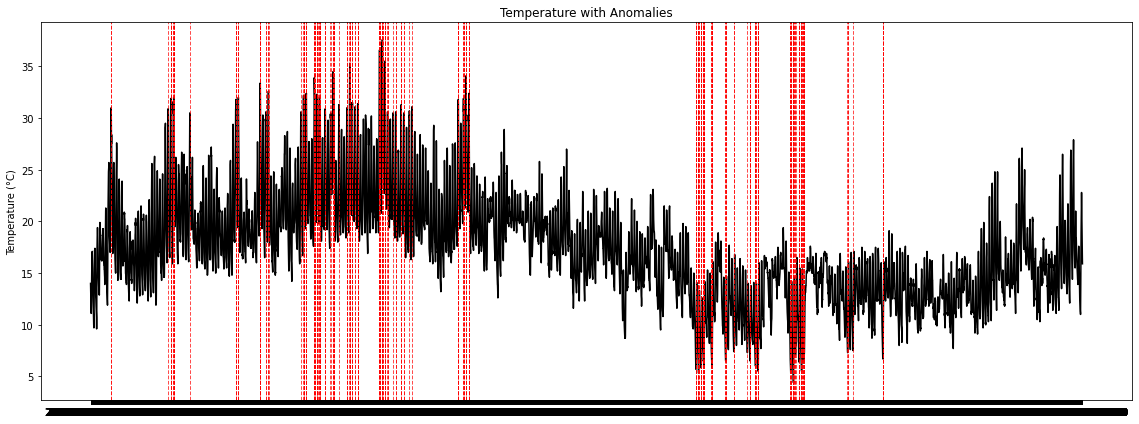

In [0]:
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot temperature as a line
ax1.plot(plot_df["time"], plot_df["temperature_2m"], color="black", label="Temperature (°C)")
ax1.set_ylabel("Temperature (°C)", color="black")
ax1.tick_params(axis='y', labelcolor="black")

# Overlay anomalies
for anomaly_time in plot_df.loc[plot_df["temperature_2m_anomaly"] == 1, "time"]:
    ax1.axvline(x=anomaly_time, color="red", linestyle="--", linewidth=1, alpha=0.7)

# Title and legend
plt.title("Temperature with Anomalies")
fig.tight_layout()
plt.show()

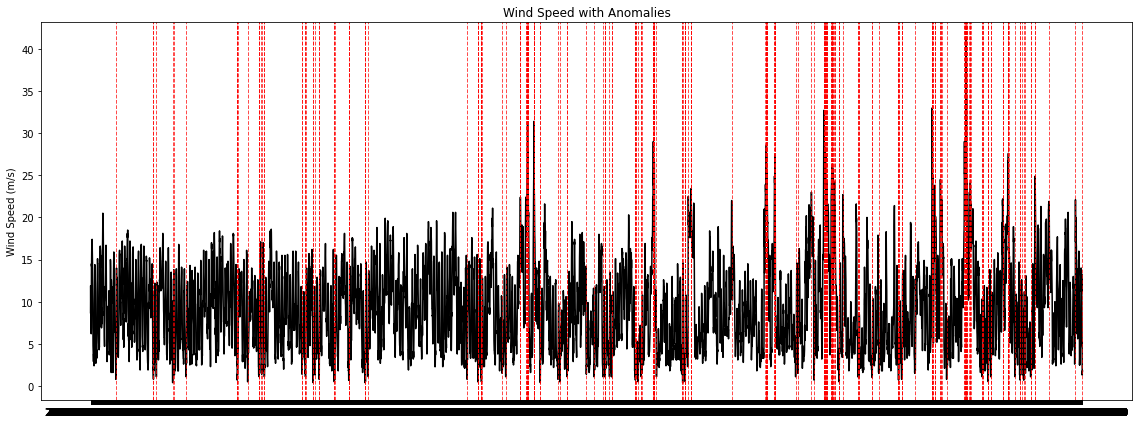

In [0]:
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot temperature as a line
ax1.plot(plot_df["time"], plot_df["wind_speed_10m"], color="black", label="Wind Speed (m/s)")
ax1.set_ylabel("Wind Speed (m/s)", color="black")
ax1.tick_params(axis='y', labelcolor="black")

# Overlay anomalies
for anomaly_time in plot_df.loc[plot_df["wind_speed_10m_anomaly"] == 1, "time"]:
    ax1.axvline(x=anomaly_time, color="red", linestyle="--", linewidth=1, alpha=0.7)

# Title and legend
plt.title("Wind Speed with Anomalies")
fig.tight_layout()
plt.show()